## Multiframe Operator Figures

This notebook contains the code for generating figures that explain the multiframe operator. First we have the convolutional definition of the operator. Then, we have the multiframe smear matrix visualized for a 1D blur.

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('/home/sarah/.config/matplotlib/deblur.mplstyle')

import imageio
import skimage.transform as skt
import skimage
import scipy.misc as misc

import libwallerlab.utilities.simulation as sim
import multiframe_vis_helper as m
import ndoperators as ops

plt.style.use('deblur')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Convolutional Figure

<IPython.core.display.Javascript object>


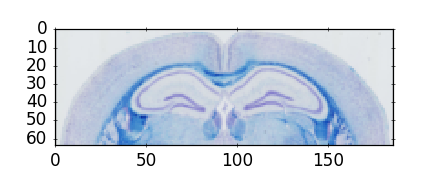

In [3]:
path = '/home/sarah/deblurring/libwallerlab/libwallerlab/resources/testimages/brain.png'
brain = imageio.imread(path)

scale_height = 128
new_shape = [scale_height, int(brain.shape[1] * scale_height / brain.shape[0])]
brain = skt.resize(brain, new_shape, anti_aliasing=True, mode='constant', preserve_range=True)


image_side = int(scale_height/2)
brain_cropped = brain[0:image_side, 0:3*image_side, :]/255


image_size = np.array([image_side, image_side])


object_true = np.real(np.array(brain_cropped))
object_size = object_true.shape[0:2]
plt.figure(figsize=(5,2))
plt.imshow(object_true)

In [8]:
W = ops.Crop(object_size, image_size, center=True)

num_images = 3
midpoint = [int(np.floor(image_size[0]/2)), int(np.floor(image_size[1]/2))]

# TODO: circular blur not ideal
shift_kernel_map = np.zeros(np.hstack([object_size, num_images]))
for i in range(num_images):
    # TODO also generate centered BLUR PATTERNS
    shift_kernel_map[midpoint[0], midpoint[1] + image_size[1]*i, i] = 1
shift_kernel = shift_kernel_map.astype(np.complex64)

S_list = []

for i in range(num_images):
    S = ops.Convolution(shift_kernel[:,:,i], mode='circular')
    S_list.append(S); 
    
import libwallerlab.projects.motiondeblur as md

n_positions = 25
point_list_linear = md.blurkernel.genLinearBlurKernelMapPositionList(object_size, n_positions, 0, centered = True)
kernel_map_linear = md.blurkernel.positionListToBlurKernelMap(object_size, point_list_linear, return_fourier = False)

point_list = point_list_linear

# TODO set a different kernel vector
data = np.load('/home/sarah/deblurring/comp_img_lunch_presentation/single_illums.npz')
kernel_vector = data['kernel_vector']
kernel_random = data['kernel_random']
blur_kernel_map = np.zeros(object_size)

for position_index, position in enumerate(point_list):
    blur_kernel_map[position[0], position[1]] = kernel_vector[position_index]

can this be replaced with blurKernelFromPositions?


<IPython.core.display.Javascript object>


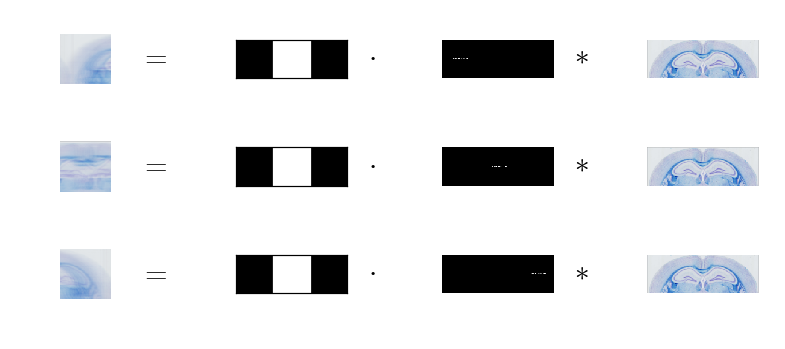

/home/sarah/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [9]:
C_list = []; A_list = []; Y_list = []; Y_list_c = []
# 2D Convolution Operator with the given kernel
for S in S_list:
    C = S * ops.Convolution(blur_kernel_map)
    A = W * C
    Y_old = A * brain_cropped[:,:,0].astype(np.complex64).reshape(-1)
    Y_inter_list = []
    for j in range(4):
        object_true = brain_cropped[:,:,j].astype(np.complex64)
        Y = A * object_true.reshape(-1)
        Y_inter_list.append(Y.reshape(image_size))
    stack_Y = np.stack(Y_inter_list, axis=2)
    C_list.append(C); A_list.append(A); Y_list.append(Y_old); Y_list_c.append(stack_Y)
    
window = W.H * W * np.ones(blur_kernel_map.size).astype(np.complex64)

plt.figure(figsize=[9,4])
for i in range(num_images):
    plt.subplot(num_images, 4, 1+4*i); plt.imshow(np.abs(Y_list_c[-(i+1)])/12.5); plt.axis('off')
    plt.text(100,40, '$=$', fontsize=24)

    plt.subplot(num_images, 4, 2+4*i); plt.imshow(np.abs(window).reshape(object_size), cmap='gray',interpolation="bilinear")
    plt.clim(0,1)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])
    plt.text(220,40, '$\cdot$', fontsize=24)
    
    shifted_blur = S_list[i] * blur_kernel_map.astype(np.complex64).reshape(-1)
    image_to_show = np.abs(shifted_blur).reshape(object_size)
    plt.subplot(num_images, 4, 3+4*i); plt.imshow(image_to_show, cmap='gray',interpolation="none")
    plt.clim(0,1)
    plt.axis('off');
    plt.text(220,40, '$*$', fontsize=24)
    plt.subplot(num_images, 4, 4+4*i); plt.imshow(brain_cropped); plt.axis('off');


plt.tight_layout()
#plt.savefig("images/window.png")


In [11]:
#plt.savefig('/home/sarah/Dropbox/deblurring/Phase-Deblurring/journalpaper/figures/multiframe_convolutional.pdf')

<IPython.core.display.Javascript object>


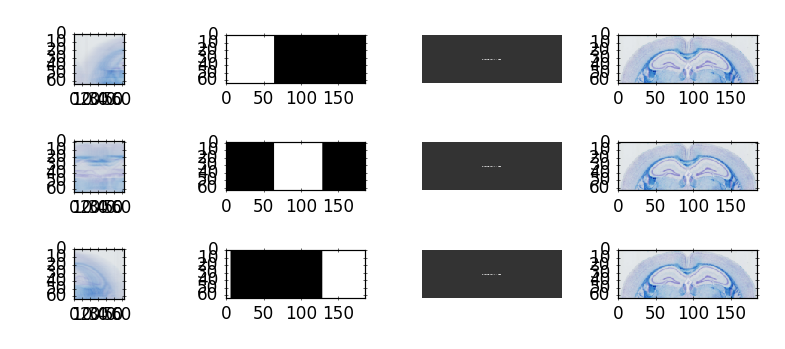

In [12]:
blur = blur_kernel_map.astype(np.complex64).reshape(-1)
image_to_show = np.abs(blur).reshape(object_size)


plt.figure(figsize=[9,4])
for i in range(num_images):
    plt.subplot(num_images, 4, 1+4*i); plt.imshow(np.abs(Y_list_c[-(i+1)])/12.5); #plt.axis('off')

    window = S_list[i] * W.H * W * np.ones(blur_kernel_map.size).astype(np.complex64)
    plt.subplot(num_images, 4, 2+4*i); plt.imshow(np.abs(window).reshape(object_size), cmap='gray',interpolation="bilinear")
    # plt.axis('off'); plt.clim(-0.25,1)
    plt.subplot(num_images, 4, 3+4*i); plt.imshow(image_to_show, cmap='gray',interpolation="bilinear")
    plt.axis('off'); plt.clim(-0.25,1)
    plt.subplot(num_images, 4, 4+4*i); plt.imshow(brain_cropped)


plt.tight_layout()

## Multiframe Smear Matrix

One-dimensional vertical blurring


[1] Chan, Stanley H., et al. "Bounds for the condition numbers of spatially-variant convolution matrices in image restoration problems." (2011).

<IPython.core.display.Javascript object>


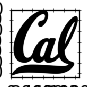

In [13]:

blur_length = 25

# Load object
ucb_logo = sim.testObject('ucblogo', (128, 128), phase=None) #sim.ucb(shape=(128, 128), phase=False)

object_true = np.abs(np.array(ucb_logo))
object_true = np.amax(object_true) - object_true
object_size = object_true.shape

object_height = object_size[0]

plt.figure(figsize=(1,1))
plt.imshow(object_true, cmap='gray')

In [14]:
window_size = 64
offset = int((3 * window_size - (object_height+blur_length)) / 2)+1

<IPython.core.display.Javascript object>


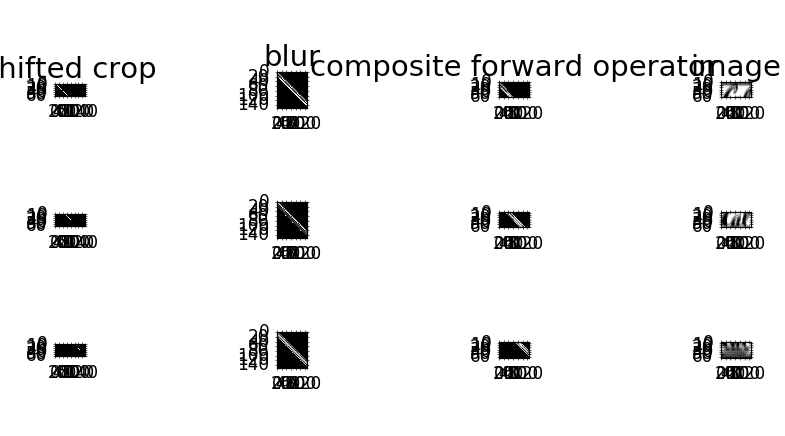

In [15]:
plt.figure(figsize=(9,5))
operators = []; illums = []
for i in range(3):
    crop = m.crop_operator(object_height+blur_length, window_size, offset=i*(64-offset))

    illumination = m.gen_illum(blur_length, 0.5, illum_type = 'pure_rand')
    blur_matrix = m.blur_matrix_1d(illumination, object_height)
    
    plt.subplot(3,4,4*i+1); plt.imshow(crop); 
    if i == 0: plt.title('shifted crop')
    plt.subplot(3,4,4*i+2); plt.imshow(blur_matrix); 
    if i == 0: plt.title('blur')
    
    operators.append(crop.dot(blur_matrix)); illums.append(illumination)

    plt.subplot(3,4,4*i+3); plt.imshow(operators[-1]); 
    if i == 0: plt.title('composite forward operator')
    plt.subplot(3,4,4*i+4); plt.imshow(crop.dot(blur_matrix.dot(object_true)), cmap='gray'); 
    if i == 0: plt.title('image')
plt.tight_layout()


<IPython.core.display.Javascript object>


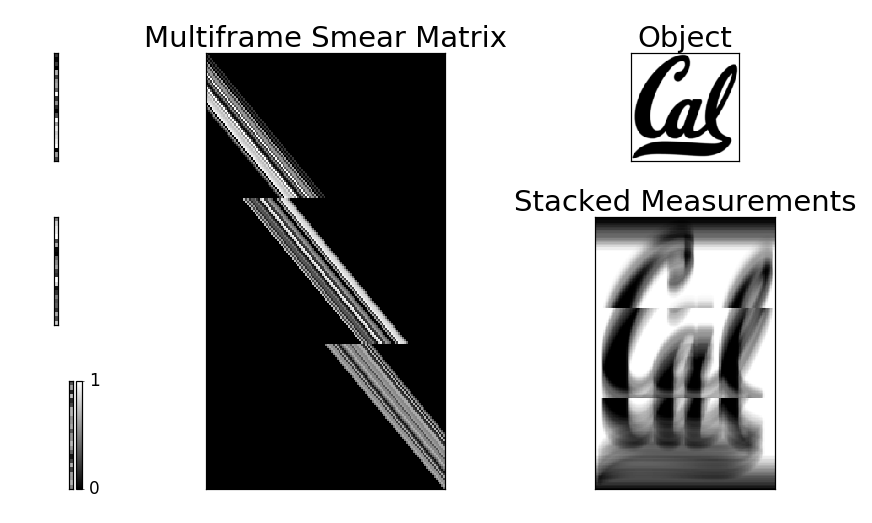

In [16]:
multiframe_operator = np.vstack(operators)

plt.figure(figsize=(10,6)); 

ax2 = plt.subplot2grid((3, 5), (0,1), rowspan=3, colspan=2)
plt.imshow(multiframe_operator, aspect='auto'); plt.title('Multiframe Smear Matrix')
plt.xticks([]); plt.yticks([]);

ax2 = plt.subplot2grid((3, 5), (0,3), rowspan=1, colspan=2)
plt.imshow(object_true, cmap='gray'); plt.title('Object')
plt.xticks([]); plt.yticks([]);

ax2 = plt.subplot2grid((3, 5), (1,3), rowspan=2, colspan=2)
plt.imshow(multiframe_operator.dot(object_true), cmap='gray'); plt.title('Stacked Measurements')
plt.xticks([]); plt.yticks([]);

ax2 = plt.subplot2grid((3, 5), (0,0), rowspan=1)
plt.imshow(np.expand_dims(illums[0], axis=1), clim=[0,1]); plt.xticks([]); plt.yticks([]); # plt.ylabel('illumination pattern ' + str(i))

ax2 = plt.subplot2grid((3, 5), (1,0), rowspan=1)
plt.imshow(np.expand_dims(illums[1], axis=1), clim=[0,1]); plt.xticks([]); plt.yticks([]); # plt.ylabel('illumination pattern ' + str(i))

ax2 = plt.subplot2grid((3, 5), (2,0), rowspan=1)
plt.imshow(np.expand_dims(illums[2], axis=1), clim=[0,1]); plt.xticks([]); plt.yticks([]); # plt.ylabel('illumination pattern ' + str(i))
cbar = plt.colorbar(ticks=[0, 1])

plt.tight_layout()

In [57]:
plt.savefig('/home/sarah/Dropbox/deblurring/Phase-Deblurring/journalpaper/figures/multiframe_smear.pdf')

/home/sarah/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
